## 模型1：Pytorch RNN 实现流程
- 1. 加载数据集
- 2. 使得数据集可迭代（每次读取一个Batch）
- 3. 创建模型类
- 4. 初始化模型类
- 5. 初始化损失类
- 6. 训练模型

In [1]:
# 1. 加载数据集
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 2. 下载mnist数据集
trainsets = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor()) # 格式转换

testsets = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

In [3]:
class_names = trainsets.classes # 查看类别/标签

print(class_names)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [4]:
# 3. 查看数据集的大小shape

print(trainsets.data.shape)

torch.Size([60000, 28, 28])


In [5]:
print(trainsets.targets.shape)

torch.Size([60000])


In [6]:
print(testsets.data.shape)

torch.Size([10000, 28, 28])


In [7]:
print(testsets.targets.shape)

torch.Size([10000])


In [8]:
# 4.定义超参数
BATCH_SIZE = 32 # 每批读取的数据大小
EPOCHS = 10 # 训练10轮

In [9]:
# 5. 创建数据集的可迭代对象，也就是说一个batch一个batch的读取数据
train_loader = torch.utils.data.DataLoader(dataset=trainsets, batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testsets, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
# 查看一批batch的数据

images, labels = next(iter(test_loader))

In [11]:
print(images.shape)

torch.Size([32, 1, 28, 28])


In [12]:
print(labels.shape)

torch.Size([32])


In [13]:
# 6. 定义函数：显示一批数据
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406]) # 均值
    std = np.array([0.229, 0.224, 0.225]) # 标准差
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # 限速值限制在0-1之间
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

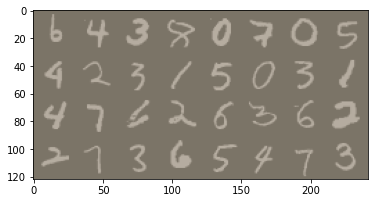

In [14]:
# 网格显示
out = torchvision.utils.make_grid(images)

imshow(out)

In [15]:
# 7. 定义RNN模型
class RNN_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN_Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        # 全连接层
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # （layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # 分离隐藏状态，避免梯度爆炸
        out, hn = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

In [16]:
# 8. 初始化模型
input_dim = 28 # 输入维度
hidden_dim = 100 # 隐层的维度
layer_dim = 2 # 2层RNN
output_dim = 10 # 输出维度

model = RNN_Model(input_dim, hidden_dim, layer_dim, output_dim)

# 判断是否有GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [17]:
# 9. 定义损失函数
criterion = nn.CrossEntropyLoss()

In [18]:
# 10. 定义优化器
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [19]:
# 11. 输出模型参数信息
length = len(list(model.parameters()))

In [20]:
# 12. 循环打印模型参数
for i in range(length):
    print('参数：%d'%(i+1))
    print(list(model.parameters())[i].size())

参数：1
torch.Size([100, 28])
参数：2
torch.Size([100, 100])
参数：3
torch.Size([100])
参数：4
torch.Size([100])
参数：5
torch.Size([100, 100])
参数：6
torch.Size([100, 100])
参数：7
torch.Size([100])
参数：8
torch.Size([100])
参数：9
torch.Size([10, 100])
参数：10
torch.Size([10])


In [21]:
# 13. 模型训练
sequence_dim = 28 # 序列长度
loss_list = [] # 保存loss
accuracy_list = [] # 保存accuracy
iteration_list = [] # 保存循环次数

iter = 0 
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        model.train() # 声明训练
        # 一个batch的数据转换为RNN的输入维度
        images = images.view(-1, sequence_dim, input_dim).requires_grad_().to(device) 
        labels = labels.to(device)
        # 梯度清零（否则会不断累加）
        optimizer.zero_grad()
        # 前向传播
        outputs = model(images)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
        # 计数器自动加1
        iter += 1
        # 模型验证
        if iter % 500 == 0:
            model.eval() # 声明
            # 计算验证的accuracy
            correct = 0.0
            total = 0.0
            # 迭代测试集，获取数据、预测
            for images, labels in test_loader:
                images = images.view(-1, sequence_dim, input_dim).to(device) 
                # 模型预测
                outputs = model(images)
                # 获取预测概率最大值的下标
                predict = torch.max(outputs.data, 1)[1]
                # 统计测试集的大小
                total += labels.size(0)
                # 统计判断/预测正确的数量
                if torch.cuda.is_available():
                    correct += (predict.gpu() == labels.gpu()).sum()
                else:
                    correct += (predict == labels).sum()
            # 计算
            accuracy = correct / total * 100
            # 保存accuracy, loss, iteration
            loss_list.append(loss.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # 打印信息
            print("loop : {}, Loss : {}, Accuracy : {}".format(iter, loss.item(), accuracy))

loos : 500, Loss : 2.29012393951416, Accuracy : 11.489999771118164
loos : 1000, Loss : 2.291365385055542, Accuracy : 12.319999694824219
loos : 1500, Loss : 2.2845988273620605, Accuracy : 17.920000076293945
loos : 2000, Loss : 2.190093994140625, Accuracy : 27.18000030517578
loos : 2500, Loss : 0.9561731815338135, Accuracy : 61.659996032714844
loos : 3000, Loss : 0.8254148960113525, Accuracy : 58.189998626708984
loos : 3500, Loss : 0.6448103785514832, Accuracy : 67.87999725341797
loos : 4000, Loss : 0.5818880796432495, Accuracy : 84.47000122070312
loos : 4500, Loss : 0.34897667169570923, Accuracy : 87.30000305175781
loos : 5000, Loss : 0.5473918318748474, Accuracy : 82.04000091552734
loos : 5500, Loss : 0.6661274433135986, Accuracy : 90.4000015258789
loos : 6000, Loss : 0.6233695149421692, Accuracy : 88.52000427246094
loos : 6500, Loss : 0.08902299404144287, Accuracy : 92.97000122070312
loos : 7000, Loss : 0.16315102577209473, Accuracy : 93.13999938964844
loos : 7500, Loss : 0.3497728705

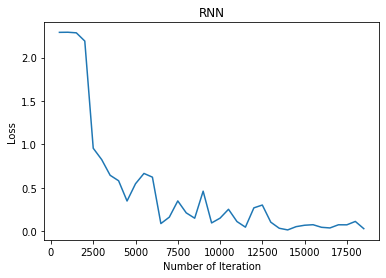

In [23]:
# 可视化 loss
plt.plot(iteration_list, loss_list)
plt.xlabel('Number of Iteration')
plt.ylabel('Loss')
plt.title('RNN')
plt.show()

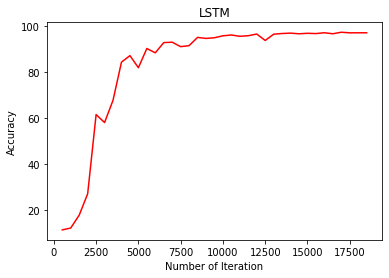

In [24]:
# 可视化 accuracy
plt.plot(iteration_list, accuracy_list, color='r')
plt.xlabel('Number of Iteration')
plt.ylabel('Accuracy')
plt.title('LSTM')
plt.savefig('LSTM_mnist.png')
plt.show()

## 模型2：LSTM 实现流程
- 1.加载数据集
- 2.使得数据集可迭代（每次读取一个Batch）
- 3.创建模型类
- 4.初始化模型类
- 5.初始化损失类
- 6.训练模型

In [25]:
# 1. 定义模型
class LSTM_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_Model, self).__init__() # 初始化父类中的构造方法
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        # 构建LSTM模型
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        # 全连接层
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # 初始化隐层状态全为0
        # (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # 初始化cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # 分离隐藏状态，以免梯度爆炸
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # 只需要最后一层隐层的状态
        out = self.fc(out[:, -1, :])
        return out

In [26]:
# 2. 初始化模型
input_dim = 28 # 输入维度，图片是28X28
hidden_dim = 100 # 隐层维度100
layer_dim =1 # 1个隐层
output_dim = 10 # 输出维度：10， 即0-9共十个数字

model = LSTM_Model(input_dim, hidden_dim, layer_dim, output_dim)

# 判断是否有GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [27]:
# 3. 循环查看
for i in range(len(list(model.parameters()))):
    print("参数：%d" %(i+1))
    print(list(model.parameters())[i].size())

参数：1
torch.Size([400, 28])
参数：2
torch.Size([400, 100])
参数：3
torch.Size([400])
参数：4
torch.Size([400])
参数：5
torch.Size([10, 100])
参数：6
torch.Size([10])


In [28]:
# 4. 初始化损失函数
criterion = nn.CrossEntropyLoss()

# 5. 初始化优化器
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [29]:
# 6. 模型训练

sequence_dim = 28 # 序列长度
loss_list = [] #  保存loss
accuracy_list = [] # 保存accuracy
iteration_list = [] # 循环次数
iter = 0 
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        model.train() # 声明模型训练
        # 一个batch的数据转换为RNN的输入维度
        images = images.view(-1, sequence_dim, input_dim).requires_grad_().to(device)
        labels = labels.to(device)
        # 梯度清零（否则会不断累积）
        optimizer.zero_grad()
        # 前向传播
        outputs = model(images)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
        # 计算器自增
        iter += 1
        # 模型验证
        if iter % 500 == 0:
            model.eval()
            # 计算accuracy
            correct = 0.0
            total = 0.0
            # 迭代测试集
            for images, labels in test_loader:
                # 一个batch的数据转换为RNN的输入维度
                images = images.view(-1, sequence_dim, input_dim).to(device)
                # 模型预测
                outputs = model(images)
                # 获取预测概率最大值的下标
                predict = torch.max(outputs.data, 1)[1]
                # 统计label的数量
                total += labels.size(0) # labels.size(0) = 32 ，即一个batchsize的大小
                # 统计预测正确的数量
                if torch.cuda.is_available():
                    correct += (predict.gpu() == labels.gpu()).sum()
                else:
                    correct += (predict == labels).sum()
            # 计算accuracy
            accuracy = correct / total * 100
            # 保存loss， accuracy，
            loss_list.append(loss.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # 打印信息
            print('loop : {} Loss : {} Accuracy : {}'.format(iter, loss.item(), accuracy))

loop : 500 Loss : 2.314399242401123 Accuracy : 11.670000076293945
loop : 1000 Loss : 2.3125665187835693 Accuracy : 11.819999694824219
loop : 1500 Loss : 2.311418056488037 Accuracy : 15.539999008178711
loop : 2000 Loss : 2.2993807792663574 Accuracy : 16.450000762939453
loop : 2500 Loss : 2.2815868854522705 Accuracy : 15.09000015258789
loop : 3000 Loss : 2.2881722450256348 Accuracy : 18.559999465942383
loop : 3500 Loss : 2.279858350753784 Accuracy : 17.889999389648438
loop : 4000 Loss : 2.269155263900757 Accuracy : 18.8700008392334
loop : 4500 Loss : 2.2419118881225586 Accuracy : 20.309999465942383
loop : 5000 Loss : 2.220203399658203 Accuracy : 23.15999984741211
loop : 5500 Loss : 2.1897337436676025 Accuracy : 23.93000030517578
loop : 6000 Loss : 2.097034454345703 Accuracy : 30.56999969482422
loop : 6500 Loss : 2.0199391841888428 Accuracy : 34.67000198364258
loop : 7000 Loss : 1.5580013990402222 Accuracy : 47.380001068115234
loop : 7500 Loss : 1.4742934703826904 Accuracy : 56.2600021362

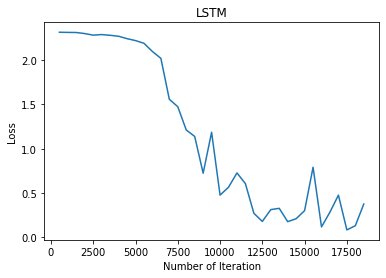

In [30]:
# 可视化loss
plt.plot(iteration_list, loss_list)
plt.xlabel('Number of Iteration')
plt.ylabel('Loss')
plt.title('LSTM')
plt.show()

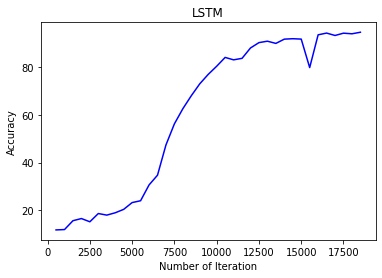

In [31]:
# 可视化accuracy
plt.plot(iteration_list, accuracy_list, color='b')
plt.xlabel('Number of Iteration')
plt.ylabel('Accuracy')
plt.title('LSTM')
plt.savefig('LSTM_accuracy.png')
plt.show()